In [1]:
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import ajf_plts

SEED = ajf_plts.get_seed("temp_to_freq_model.ipynb")

In [2]:
plt.style.use(["./ajf_plts/base.mplstyle", "./ajf_plts/legend_frame.mplstyle"])

This code does the follow steps:
* Joins together the various MIDAS year files
* Converts the index to be half hourly to match the SSI freqs
* Interpolates the NaNs that are placed at the half hour positions

# Load MIDAS weather data

In [3]:
midas_df = pd.concat(
    [
        pd.read_csv(
            f,
            engine="python",
            skiprows=280,
            skipfooter=1,
            usecols=["ob_time", "air_temperature"],
            parse_dates=["ob_time"],
            infer_datetime_format=True,
            index_col=["ob_time"],
        ).dropna()
        for f in glob.glob("midas-*.csv")
    ]
).asfreq("1H")

print(midas_df)
midas_df.describe()

                     air_temperature
ob_time                             
2018-01-01 00:00:00              3.9
2018-01-01 01:00:00              3.8
2018-01-01 02:00:00              4.1
2018-01-01 03:00:00              4.0
2018-01-01 04:00:00              4.3
...                              ...
2020-12-31 19:00:00              4.9
2020-12-31 20:00:00              4.7
2020-12-31 21:00:00              4.7
2020-12-31 22:00:00              4.4
2020-12-31 23:00:00              3.8

[26304 rows x 1 columns]


,air_temperature
count,26286.000000
mean,9.429084
std,4.928099
min,-4.100000
25%,5.800000
50%,9.100000
75%,12.900000
max,28.600000


## Fill in missing values

In [4]:
print(midas_df[midas_df.isna().values])

                     air_temperature
ob_time                             
2018-01-05 13:00:00              NaN
2018-01-05 14:00:00              NaN
2018-01-05 15:00:00              NaN
2018-07-18 11:00:00              NaN
2018-07-18 12:00:00              NaN
2018-07-25 16:00:00              NaN
2018-07-25 17:00:00              NaN
2018-07-25 18:00:00              NaN
2018-07-25 19:00:00              NaN
2019-01-28 13:00:00              NaN
2019-01-28 14:00:00              NaN
2019-07-24 12:00:00              NaN
2019-07-24 13:00:00              NaN
2019-08-02 16:00:00              NaN
2019-11-12 14:00:00              NaN
2019-11-12 15:00:00              NaN
2020-01-16 11:00:00              NaN
2020-01-16 12:00:00              NaN


In [5]:
midas_df = midas_df.interpolate().reset_index().rename(columns={"ob_time": "time"})
print(midas_df)

                     time  air_temperature
0     2018-01-01 00:00:00              3.9
1     2018-01-01 01:00:00              3.8
2     2018-01-01 02:00:00              4.1
3     2018-01-01 03:00:00              4.0
4     2018-01-01 04:00:00              4.3
...                   ...              ...
26299 2020-12-31 19:00:00              4.9
26300 2020-12-31 20:00:00              4.7
26301 2020-12-31 21:00:00              4.7
26302 2020-12-31 22:00:00              4.4
26303 2020-12-31 23:00:00              3.8

[26304 rows x 2 columns]


# Load in bridge frequency data

In [6]:
import scipy.io

mode_1_mat = scipy.io.loadmat("mode_1.mat")

time1 = pd.to_datetime(mode_1_mat["Time"].reshape(-1), unit="s")
freq1 = mode_1_mat["Frequency"].reshape(-1)
temp1 = mode_1_mat["TempT_0"].reshape(-1)

gh_df = pd.DataFrame({"time": time1, "freq": freq1}).sort_values("time")
print(gh_df)
gh_df.describe()

                     time      freq
0     2018-10-19 06:17:06  5.707690
1     2018-10-19 06:47:06  5.705696
2     2018-10-19 07:17:06  5.713192
3     2018-10-19 07:47:06  5.689763
4     2018-10-19 08:17:06  5.675845
...                   ...       ...
18426 2021-03-30 04:47:20  5.693058
18427 2021-03-30 05:17:20  5.702516
18428 2021-03-30 05:47:21  5.684138
18429 2021-03-30 06:17:21  5.658545
18430 2021-03-30 06:47:21  5.679977

[18431 rows x 2 columns]


,freq
count,18431.000000
mean,5.683987
std,0.130653
min,5.003418
25%,5.594548
50%,5.708642
75%,5.766512
max,6.492711


In [7]:
df = pd.merge_asof(
    left=midas_df,
    right=gh_df,
    on="time",
    tolerance=pd.Timedelta("1H"),
    direction="nearest",
).set_index("time")

# remove nans at top and tail of dataset
df = df.loc[df.dropna().index.min() <= df.index]
df = df.loc[df.index <= df.dropna().index.max()]

full_df = df.copy()
print(df)

                     air_temperature      freq
time                                          
2018-10-19 06:00:00              8.2  5.707690
2018-10-19 07:00:00              8.4  5.705696
2018-10-19 08:00:00              8.6  5.689763
2018-10-19 09:00:00              8.8  5.680789
2018-10-19 10:00:00              9.7  5.705422
...                              ...       ...
2020-12-23 21:00:00              3.0  5.849363
2020-12-23 22:00:00              2.5  5.849589
2020-12-23 23:00:00              2.4  5.857112
2020-12-24 00:00:00              3.6  5.844593
2020-12-24 01:00:00              3.9  5.881038

[19124 rows x 2 columns]


In [8]:
axvspan_paras = dict(ec="none", fc="grey", zorder=-100)

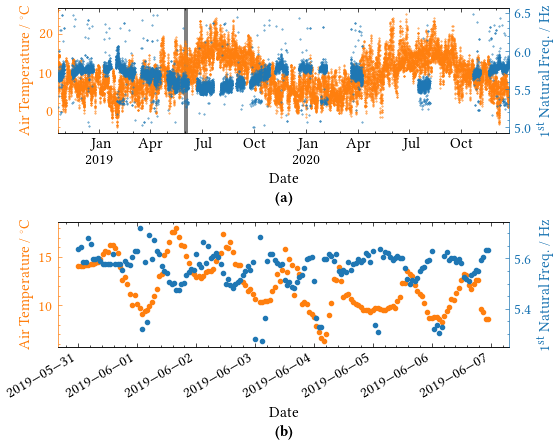

In [9]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, 2.0 * ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=1, nrows=2)

freq_vals = df.freq.dropna()

axes2 = [ax.twinx() for ax in axes]

df.air_temperature.plot(
    ax=axes[0], ls="", c="C1", marker=".", markersize=0.75, rasterized=True
)
df.freq.plot(ax=axes2[0], ls="", c="C0", marker=".", markersize=0.75, rasterized=True)

start_date = "2019-5-31"
end_date = "2019-6-7"

mask = (df.index >= start_date) & (df.index <= end_date)
df[mask].dropna().air_temperature.plot(ax=axes[1], ls="", c="C1", marker=".")
df[mask].dropna().freq.plot(ax=axes2[1], ls="", c="C0", marker=".")

axes[0].axvspan(start_date, end_date, **axvspan_paras)

for ax in axes:
    ax.set_xlabel("Date")

for ax in axes:
    ax.set_ylabel(r"Air Temperature / \unit{\celsius}", c="C1")
    ax.tick_params(axis="y", which="both", colors="C1")
    ax.spines["left"].set_color("C1")
    ax.spines["right"].set_visible(False)

for ax in axes2:
    ax.set_ylabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}", c="C0")
    ax.tick_params(axis="y", which="both", colors="C0")
    ax.spines["right"].set_color("C0")
    ax.spines["left"].set_visible(False)

ajf_plts.caption_axes(axes)
fig.tight_layout()
ajf_plts.save_fig(fig, "figRawFirstFrequenciesTemps.pdf")

## Find outliers

In [10]:
def median_absolute_deviation(x):
    """
    Returns the median absolute deviation from the window's median
    :param x: Values in the window
    :return: MAD
    """
    return np.median(np.abs(x - np.median(x)))


def hampel(ts, window_size=5, n=3, imputation=False):

    """
    Median absolute deviation (MAD) outlier in Time Series
    :param ts: a pandas Series object representing the timeseries
    :param window_size: total window size will be computed as 2*window_size + 1
    :param n: threshold, default is 3 (Pearson's rule)
    :param imputation: If set to False, then the algorithm will be used for outlier detection.
        If set to True, then the algorithm will also imput the outliers with the rolling median.
    :return: Returns the outlier indices if imputation=False and the corrected timeseries if imputation=True
    """

    if type(ts) != pd.Series:
        raise ValueError("Timeserie object must be of tyme pandas.Series.")

    #    if type(window_size) == int:
    #        raise ValueError("Window size must be of type integer.")
    #    else:
    #        if window_size <= 0:
    #            raise ValueError("Window size must be more than 0.")
    #
    #     if type(n) != int:
    #         raise ValueError("Window size must be of type integer.")
    #     else:
    #         if n < 0:
    #             raise ValueError("Window size must be equal or more than 0.")

    # Copy the Series object. This will be the cleaned timeserie
    ts_cleaned = ts.copy()

    # Constant scale factor, which depends on the distribution
    # In this case, we assume normal distribution
    rolling_ts = ts_cleaned.rolling(window_size, min_periods=1, center=True)
    rolling_median = rolling_ts.median().fillna(method="bfill").fillna(method="ffill")
    rolling_mad = (
        rolling_ts.apply(median_absolute_deviation)
        .fillna(method="bfill")
        .fillna(method="ffill")
    )

    outlier_indices = list(
        np.array(
            np.where(np.abs(ts_cleaned - rolling_median) >= (n * rolling_mad))
        ).flatten()
    )

    if imputation:
        ts_cleaned[outlier_indices] = rolling_median[outlier_indices]
        return ts_cleaned

    return outlier_indices


# df = full_df.copy()

outliers = hampel(ts=df.freq, window_size=int(24), n=3.5)
df.freq.iloc[outliers] = np.nan

outlier_df = df.copy()
outlier_df.freq = np.nan
outlier_df.iloc[outliers] = full_df.iloc[outliers]

print(len(outliers))

735


In [11]:
outlier_df

,air_temperature,freq
time,,
2018-10-19 06:00:00,8.2,NaN
2018-10-19 07:00:00,8.4,NaN
2018-10-19 08:00:00,8.6,NaN
2018-10-19 09:00:00,8.8,NaN
2018-10-19 10:00:00,9.7,NaN
...,...,...
2020-12-23 21:00:00,3.0,NaN
2020-12-23 22:00:00,2.5,NaN
2020-12-23 23:00:00,2.4,NaN


In [12]:
outlier_df.isna().sum()

air_temperature        0
freq               18389
dtype: int64

## Check outliers are at night

Total outliers: N=735 (3.84%)

Day outliers:   N=74 (10.07%)
Night outliers: N=661 (89.93%)


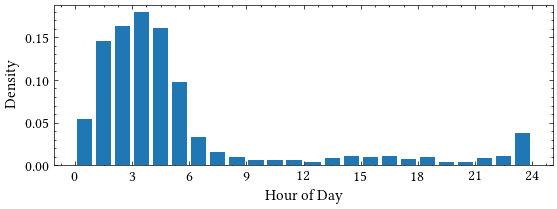

In [13]:
outlier_hours = df.index[outliers].hour

day_hours = np.arange(7, 19)

day_outliers = outlier_hours.isin(day_hours).sum()
night_outliers = (~(outlier_hours.isin(day_hours))).sum()

print(f"Total outliers: N={len(outliers)} ({len(outliers)/len(df):2.2%})")
print()
print(
    f"Day outliers:   N={day_outliers} ({day_outliers/(day_outliers+night_outliers):2.2%})"
)
print(
    f"Night outliers: N={night_outliers} ({night_outliers/(day_outliers+night_outliers):2.2%})"
)

%matplotlib widget
figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)
outlier_hours.to_series().plot(
    kind="hist", density=True, rwidth=0.8, bins=np.arange(25)
)
ax.set_xlabel("Hour of Day")
ax.set_xticks(np.arange(25)[::3])
ax.set_ylabel("Density")
fig.tight_layout()
ajf_plts.save_fig(fig, "figOutlierTimes.pdf")

## Interpolate gaps

In [14]:
interp_df = df.copy().dropna()

max_gap = pd.Timedelta("6H")
interp_df["time"] = interp_df.index
interp_df["block_id"] = ((interp_df.time - interp_df.time.shift()) > max_gap).cumsum()
interp_df = interp_df.drop(columns="time").asfreq("1H")
interp_df["block_id"] = interp_df.block_id.ffill()

groups = []
for i, group in interp_df.groupby(by="block_id"):
    #groups.append(group.interpolate(method="linear", limit=6, limit_area="inside"))
    groups.append(group.interpolate(method="cubic", limit=6, limit_area="inside"))
interp_df = pd.concat(groups)

In [15]:
interpolated = full_df.loc[interp_df.index].freq != interp_df.freq

In [16]:
n_interpolated = (
    interp_df.freq.dropna().size - full_df.loc[interp_df.index].freq.dropna().size
)
print(f"Num interpolated = {n_interpolated}")
print(f"% interpolated = {n_interpolated/len(full_df.dropna()):2.2%}")

Num interpolated = 104
% interpolated = 1.11%


## Plot

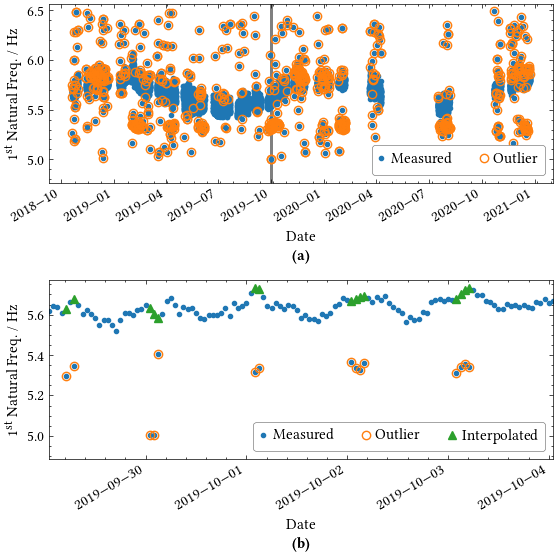

In [17]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, 2.5 * ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, nrows=2)
axes = axes.ravel()

obs_props = dict(
    ls="", marker=".", markersize=6.0, c="C0", label="Measured", rasterized=True
)
out_props = dict(
    ls="",
    marker="o",
    markersize=6.0,
    c="C1",
    markerfacecolor="none",
    label="Outlier",
    rasterized=True,
)
int_props = dict(
    ls="", marker="^", markersize=6.0, c="C2", label="Interpolated", rasterized=True
)

# OVERALL PLOT
axes[0].plot(full_df.freq, **obs_props)
axes[0].plot(full_df.freq[outliers], **out_props)
axes[0].set_ylim(axes[0].get_ylim() + [-0.1, 0.0] * np.diff(axes[0].get_ylim()))

# ZOOM IN
start = pd.Timestamp("2019-09-29 01:00:00")
end = start + pd.Timedelta("5d")
mask = (start <= full_df.index) * (full_df.index <= end)

axes[1].plot(full_df.freq[mask], **obs_props)
axes[1].plot(outlier_df.freq[mask], **out_props)
axes[1].plot(interp_df.freq[interpolated * mask], **int_props)
axes[1].set_ylim(axes[1].get_ylim() + [-0.1, 0.0] * np.diff(axes[1].get_ylim()))

axes[1].set_xlim((start, end))
axes[0].axvspan(start, end, **axvspan_paras)

for ax in axes:
    ax.set_xlabel("Date")
    ax.set_ylabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}")
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
    legend = ax.legend(
        loc="lower right", ncol=3, borderpad=0.5, handlelength=0.25, handletextpad=0.5
    )

ajf_plts.caption_axes(axes)
fig.tight_layout()

ajf_plts.save_fig(fig, "figFreqOutlierInterp.pdf")

# test train split

In [18]:
all_df = interp_df.dropna().copy()

n_points = len(all_df)
train_prop = 0.6
split_ind = all_df.index.values[int(n_points * train_prop)]

min_ind = all_df.index.min()
max_ind = all_df.index.max()

train_df = interp_df.loc[
    (min_ind <= interp_df.index) * (interp_df.index <= split_ind)
].copy()
test_df = interp_df.loc[
    (split_ind < interp_df.index) * (interp_df.index <= max_ind)
].copy()

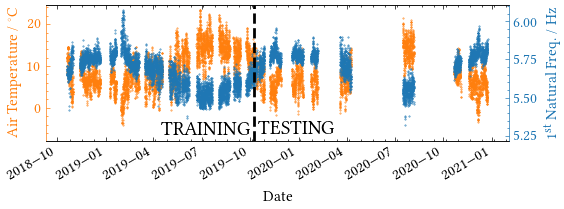

In [19]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize, ncols=1, nrows=1)

freq_vals = df.freq.dropna()

ax2 = ax.twinx()

all_df.air_temperature.plot(
    ax=ax, ls="", c="C1", marker=".", markersize=0.75
).set_rasterized(True)

all_df.freq.plot(ax=ax2, ls="", c="C0", marker=".", markersize=0.75).set_rasterized(
    True
)

ax.set_xlabel("Date")

ax.set_ylabel(r"Air Temperature / \unit{\celsius}", c="C1")
ax.tick_params(axis="y", which="both", colors="C1")
ax.spines["left"].set_color("C1")
ax.spines["right"].set_visible(False)

ax2.set_ylabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}", c="C0")
ax2.tick_params(axis="y", which="both", colors="C0")
ax2.spines["right"].set_color("C0")
ax2.spines["left"].set_visible(False)


for ax in [ax, ax2]:
    ax.set_ylim(ax.get_ylim() + [-0.08, 0.0] * np.diff(ax.get_ylim()))

ajf_plts.annotate_train_test_split(ax2, split_ind, pd.Timedelta("200H"))

fig.tight_layout()
ajf_plts.save_fig(fig, "figTrainTestSplit.pdf")

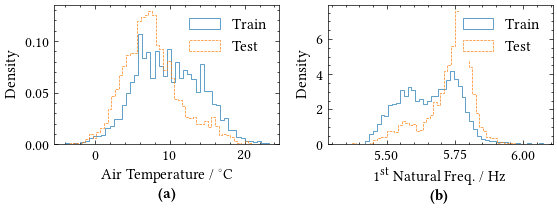

In [20]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=2, nrows=1)

axes = axes.ravel()

ax_props = dict(kind="hist", bins=50, density=True, histtype="step", label="Train")

train_df.air_temperature.plot(ax=axes[0], **ax_props)
train_df.freq.plot(ax=axes[1], **ax_props)

ax_props["label"] = "Test"

test_df.air_temperature.plot(ax=axes[0], **ax_props)
test_df.freq.plot(ax=axes[1], **ax_props)

axes[0].set_xlabel(r"Air Temperature / \unit{\celsius}")
axes[1].set_xlabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}")
for ax in axes:
    ax.set_ylabel("Density")
    ax.legend(edgecolor="None")

ajf_plts.caption_axes(axes)
fig.tight_layout()

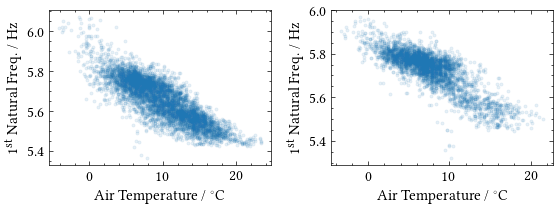

In [21]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=2, nrows=1)

axes = axes.ravel()

ax_props = dict(kind="scatter", marker=".", alpha=0.1)

train_df.plot(ax=axes[0], x="air_temperature", y="freq", **ax_props)

test_df.plot(ax=axes[1], x="air_temperature", y="freq", **ax_props)

for ax in axes:
    ax.set_xlabel(r"Air Temperature / \unit{\celsius}")
    ax.set_ylabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}")

fig.tight_layout()

## seasonal trend loess decomposition

In [22]:
import statsmodels.api as sm

In [23]:
sd_parameters = dict(
    model="add", period=2 * 24, two_sided=True, extrapolate_trend="freq"
)  # 2*24 for the period makes this the classical seasonal decompose by Persons 1919

train_temp_sd = sm.tsa.seasonal_decompose(
    train_df.dropna().air_temperature, **sd_parameters
)
train_freq_sd = sm.tsa.seasonal_decompose(train_df.dropna().freq, **sd_parameters)
trend_train_df = pd.concat([train_temp_sd.trend, train_freq_sd.trend], axis=1).set_axis(
    ["air_temperature", "freq"], axis=1
)
daily_train_df = pd.concat(
    [
        train_temp_sd.seasonal + train_temp_sd.resid,
        train_freq_sd.seasonal + train_freq_sd.resid,
    ],
    axis=1,
).set_axis(["air_temperature", "freq"], axis=1)

test_temp_sd = sm.tsa.seasonal_decompose(
    test_df.dropna().air_temperature, **sd_parameters
)
test_freq_sd = sm.tsa.seasonal_decompose(test_df.dropna().freq, **sd_parameters)
trend_test_df = pd.concat([test_temp_sd.trend, test_freq_sd.trend], axis=1).set_axis(
    ["air_temperature", "freq"], axis=1
)
daily_test_df = pd.concat(
    [
        test_temp_sd.seasonal + test_temp_sd.resid,
        test_freq_sd.seasonal + test_freq_sd.resid,
    ],
    axis=1,
).set_axis(["air_temperature", "freq"], axis=1)

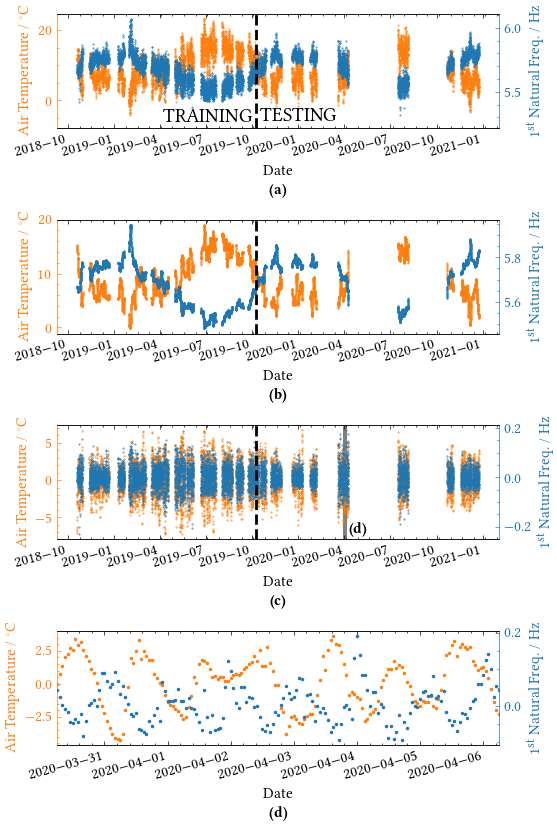

In [24]:
figsize = (ajf_plts.text_width_inches, ajf_plts.text_height_inches)
fig, axes = plt.subplots(figsize=figsize, nrows=4, ncols=1)

axes2 = [ax.twinx() for ax in axes]

temp_col = "C1"
freq_col = "C0"

props = dict(ls="", marker=".", markersize=0.75, rasterized=True)

# plot original
axes[0].plot(train_df.air_temperature, **props, c=temp_col)
axes[0].plot(test_df.air_temperature, **props, c=temp_col)
axes2[0].plot(train_df.freq, **props, c=freq_col)
axes2[0].plot(test_df.freq, **props, c=freq_col)

# plot trend
axes[1].plot(trend_train_df.air_temperature, **props, c=temp_col)
axes[1].plot(trend_test_df.air_temperature, **props, c=temp_col)
axes2[1].plot(trend_train_df.freq, **props, c=freq_col)
axes2[1].plot(trend_test_df.freq, **props, c=freq_col)

# plot seasonal
axes[2].plot(daily_train_df.air_temperature, **props, c=temp_col)
axes[2].plot(daily_test_df.air_temperature, **props, c=temp_col)
axes2[2].plot(daily_train_df.freq, **props, c=freq_col)
axes2[2].plot(daily_test_df.freq, **props, c=freq_col)

# plot seasonal
props["markersize"] = 3.0
start = pd.Timestamp("2020-03-30 06:00:00")
end = start + pd.Timedelta("7d")
mask = (start <= daily_test_df.index) * (daily_test_df.index <= end)
axes[3].plot(daily_test_df.air_temperature[mask], **props, c=temp_col)
axes2[3].plot(daily_test_df.freq[mask], **props, c=freq_col)
axes[3].set_xlim((start, end))
axes[2].axvspan(start, end, **axvspan_paras)

for ax, ax2 in zip(axes, axes2):
    ax.set_ylabel(r"Air Temperature / \unit{\celsius}", c="C1")
    ax.tick_params(axis="y", which="both", colors="C1")
    ax.spines["left"].set_color("C1")
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Date")

    ax2.set_ylabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}", c="C0")
    ax2.tick_params(axis="y", which="both", colors="C0")
    ax2.spines["right"].set_color("C0")
    ax2.spines["left"].set_visible(False)

for ax, ax2 in zip(axes[:-1], axes2[:-1]):
    ax.xaxis.set_major_locator(mpl.dates.MonthLocator(interval=3))
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right")

axes[0].set_ylim(axes[0].get_ylim() + [-0.08, 0.0] * np.diff(axes[0].get_ylim()))
axes2[0].set_ylim(axes2[0].get_ylim() + [-0.08, 0.0] * np.diff(axes2[0].get_ylim()))
ajf_plts.annotate_train_test_split(axes2[0], split_ind, pd.Timedelta("200H"))

for ax in axes2[1:-1]:
    ajf_plts.annotate_train_test_split(
        ax, split_ind, pd.Timedelta("200H"), label_on=False
    )

axes[3].xaxis.set_major_locator(mpl.dates.DayLocator())
plt.setp(axes[3].get_xticklabels(), rotation=15, ha="right")

axes2[2].annotate(
    r"\bfseries (d)",
    xy=(
        end + pd.Timedelta("100H"),
        axes2[2]
        .transData.inverted()
        .transform((0.0, axes2[2].transAxes.transform((0.0, 0.02))[1]))[1],
    ),
    ha="left",
    va="bottom",
    fontsize=11.0,
)


ajf_plts.caption_axes(axes)
fig.tight_layout()
ajf_plts.save_fig(fig, "figSeasonalDecompose.pdf")

Part A: Raw data, clearly when you look at the data there is an annual trend and a daily trend. (Persons 1919) classical seasonal decomposition using cnetered moving average, more recently this has been used for X, Y, Z.

Secondly, doing it this way allows for the difference between the boundary condition changes that happen between an annual cycle and daily cycle being different.

## fitting linear model to trend component

In [25]:
import warnings

warnings.simplefilter("ignore", sm.tools.sm_exceptions.InterpolationWarning)

# check for stationarity
alpha = 0.05
x = trend_train_df.dropna().air_temperature.values
x = x.reshape(-1, 1)
y = trend_train_df.dropna().freq.values

adf_res = sm.tsa.stattools.adfuller(x)
kpss_res = sm.tsa.stattools.kpss(x)
print(f"x")
print(f"ADF says {'non-stationary' if adf_res[1] > alpha else 'stationary'}")
print(f"KPSS says {'non-stationary' if kpss_res[1] < alpha else 'stationary'}")
print("")

adf_res = sm.tsa.stattools.adfuller(np.diff(x, axis=0))
kpss_res = sm.tsa.stattools.kpss(np.diff(x, axis=0))
print(f"1st order difference of x")
print(f"ADF says {'non-stationary' if adf_res[1] > alpha else 'stationary'}")
print(f"KPSS says {'non-stationary' if kpss_res[1] < alpha else 'stationary'}")
print("")

adf_res = sm.tsa.stattools.adfuller(y)
kpss_res = sm.tsa.stattools.kpss(y)
print(f"y")
print(f"ADF says {'non-stationary' if adf_res[1] > alpha else 'stationary'}")
print(f"KPSS says {'non-stationary' if kpss_res[1] < alpha else 'stationary'}")
print("")

adf_res = sm.tsa.stattools.adfuller(np.diff(y, axis=0))
kpss_res = sm.tsa.stattools.kpss(np.diff(y, axis=0))
print(f"1st order difference of y")
print(f"ADF says {'non-stationary' if adf_res[1] > alpha else 'stationary'}")
print(f"KPSS says {'non-stationary' if kpss_res[1] < alpha else 'stationary'}")
print("")

x
ADF says stationary
KPSS says non-stationary

1st order difference of x
ADF says stationary
KPSS says stationary

y
ADF says non-stationary
KPSS says non-stationary

1st order difference of y
ADF says stationary
KPSS says stationary



In [26]:
# test for cointegration
eg_test = sm.tsa.coint(y, x, maxlag=24, autolag="AIC", trend="c")

print(
    f"Engle-Granger two-step cointegration test says {'cointegrated' if eg_test[1] < alpha else 'not cointegrated'}"
)

Engle-Granger two-step cointegration test says cointegrated


In [27]:
X = sm.add_constant(x)
Y = y

model = sm.OLS(endog=Y, exog=X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                 2.214e+04
Date:                Sun, 28 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:56:57   Log-Likelihood:                 9630.9
No. Observations:                5663   AIC:                        -1.926e+04
Df Residuals:                    5661   BIC:                        -1.924e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8785      0.002   3663.331      0.000       5.875       5.882
x1            -0.0227      0.000   -148.790      0.000      -0.023      -0.022
==============================================================================
Omnibus:                       58.415   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.591
Skew:                          -0.244   Prob(JB):                     1.15e-13
Kurtosis:                       2.880   Cond. No.                         28.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
x_test = trend_test_df.dropna().air_temperature.values.reshape(-1, 1)
y_test = trend_test_df.dropna().freq.values

In [29]:
trend_train_preds = res.predict()
trend_test_preds = res.predict(exog=sm.add_constant(x_test))

trend_train_res = y - trend_train_preds
trend_test_res = y_test - trend_test_preds

In [30]:
from sklearn.metrics import mean_squared_error

print(
    "Train RMSE: %.3f Hz"
    % (np.sqrt(mean_squared_error(trend_train_df.dropna().freq, trend_train_preds)))
)
print(
    "Test RMSE: %.3f Hz"
    % (np.sqrt(mean_squared_error(trend_test_df.dropna().freq, trend_test_preds)))
)

Train RMSE: 0.044 Hz
Test RMSE: 0.039 Hz


In [31]:
actual_col = "C0"
predict_col = "C6"
train_col = "C3"
test_col = "C4"

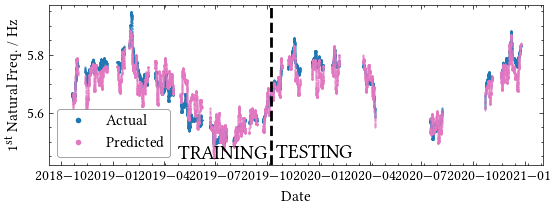

In [32]:
figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)

actual_paras = dict(ls="", marker=".", c=actual_col, markersize=0.75, rasterized=True)
predict_paras = dict(ls="", marker=".", c=predict_col, markersize=0.75, rasterized=True)

ax.plot(trend_train_df.dropna().freq, label="Actual", **actual_paras)
ax.plot(trend_test_df.dropna().freq, label="_Actual", **actual_paras)

ax.plot(
    trend_train_df.dropna().index, trend_train_preds, **predict_paras, label="Predicted"
)
ax.plot(
    trend_test_df.dropna().index, trend_test_preds, **predict_paras, label="_Predicted"
)

ax.axvline(split_ind, ls="--", c="k", lw="2.0")
ax.annotate(
    "TRAINING",
    xy=(
        split_ind - pd.Timedelta("200H"),
        ax.transData.inverted().transform(
            (0.0, ax.transAxes.transform((0.0, 0.01))[1])
        )[1],
    ),
    ha="right",
    va="bottom",
    fontsize=14.0,
    fontweight="bold",
)
ax.annotate(
    "TESTING",
    xy=(
        split_ind + pd.Timedelta("200H"),
        ax.transData.inverted().transform(
            (0.0, ax.transAxes.transform((0.0, 0.01))[1])
        )[1],
    ),
    ha="left",
    va="bottom",
    fontsize=14.0,
    fontweight="bold",
    zorder=10,
)

ax.set_xlabel("Date")
ax.set_ylabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}")
legend = ax.legend()

for lh in legend.legendHandles:
    lh.set_markersize(6)

fig.tight_layout()
ajf_plts.save_fig(fig, "figTrendOLSfit.pdf")

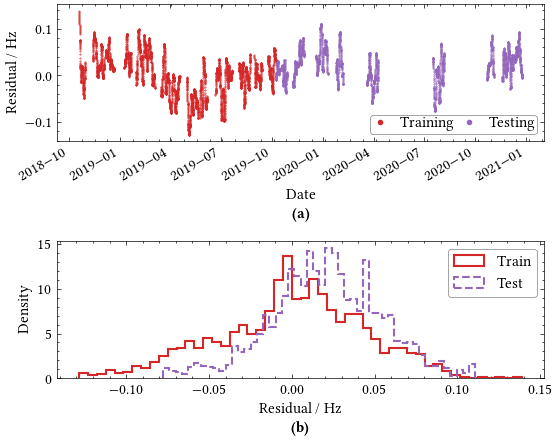

In [33]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, 2.0 * ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, nrows=2)

props = dict(ls="", marker=".", markersize=0.75, rasterized=True)

axes[0].plot(
    trend_train_df.dropna().index,
    trend_train_res,
    **props,
    c=train_col,
    label="Training"
)
axes[0].plot(
    trend_test_df.dropna().index, trend_test_res, **props, c=test_col, label="Testing"
)

axes[0].set_xlabel("Date")
axes[0].set_ylabel("Residual / Hz")
plt.setp(axes[0].get_xticklabels(), rotation=30, ha="right")

# axes[1].plot(trend_train_preds, trend_train_res, **props, c=train_col, label='Training')
# axes[1].plot(trend_test_preds, trend_test_res, **props, c=test_col, label='Testing')
# axes[1].set_xlabel('Predicted Frequency / Hz')
# axes[1].set_ylabel('Residual / Hz')

ax_props = dict(bins=50, density=True, histtype="step", lw=1.5)

axes[1].hist(trend_train_res, **ax_props, ec=train_col, label="Train")
axes[1].hist(trend_test_res, **ax_props, ec=test_col, label="Test")
axes[1].set_xlabel(r"Air Temperature / \unit{\celsius}")
axes[1].set_xlabel(r"Residual / \unit{\hertz}")
axes[1].set_ylabel("Density")
legend = axes[1].legend(loc="upper right")

for ax in axes[[0]]:
    legend = ax.legend(
        loc="lower right", ncol=2, borderpad=0.15, handlelength=1.0, columnspacing=0.5
    )
    for lh in legend.legendHandles:
        lh.set_markersize(6)
        lh.set_alpha(1.0)


ajf_plts.caption_axes(axes)
fig.tight_layout()

# fit AR model to Air temperature

In [34]:
# check for stationarity
alpha = 0.05
x = daily_train_df.air_temperature.values
x = x.reshape(-1, 1)
y = daily_train_df.freq.values

In [35]:
adf_res = sm.tsa.stattools.adfuller(x)
kpss_res = sm.tsa.stattools.kpss(x)
print(f"ADF says {'non-stationary' if adf_res[1] > alpha else 'stationary'}")
print(f"KPSS says {'non-stationary' if kpss_res[1] < alpha else 'stationary'}")

ADF says stationary
KPSS says stationary


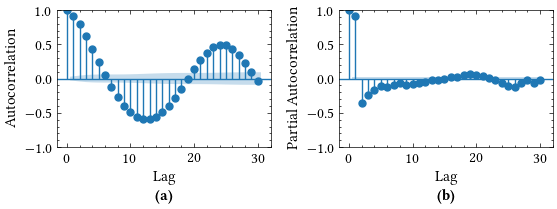

In [36]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=2)

_ = sm.tsa.graphics.plot_acf(x, lags=30, ax=axes[0], title="")
axes[0].set_ylabel("Autocorrelation")

_ = sm.tsa.graphics.plot_pacf(x, lags=30, method="ywm", ax=axes[1], title="")
axes[1].set_ylabel("Partial Autocorrelation")

for ax in axes:
    ax.set_xlabel("Lag")

ajf_plts.caption_axes(axes)
fig.tight_layout()

In [37]:
for l in np.arange(9):
    model = sm.tsa.ARIMA(endog=x, order=(l, 0, 0), trend="n").fit()
    print(
        f"Lags: {l} AIC:{model.aic:.0f} BIC={model.bic:.0f} LL={model.llf:.0f} RMSE={np.sqrt(model.mse)}"
    )

Lags: 0 AIC:24241 BIC=24247 LL=-12119 RMSE=2.0567883722578206
Lags: 1 AIC:13653 BIC=13666 LL=-6825 RMSE=0.8120769134999931
Lags: 2 AIC:12874 BIC=12894 LL=-6434 RMSE=0.7587078182434471
Lags: 3 AIC:12552 BIC=12578 LL=-6272 RMSE=0.7376211810425399
Lags: 4 AIC:12389 BIC=12422 LL=-6189 RMSE=0.7271369238802833
Lags: 5 AIC:12328 BIC=12368 LL=-6158 RMSE=0.7231779546816599
Lags: 6 AIC:12254 BIC=12300 LL=-6120 RMSE=0.7184089525316566
Lags: 7 AIC:12210 BIC=12263 LL=-6097 RMSE=0.7155542815589296
Lags: 8 AIC:12184 BIC=12244 LL=-6083 RMSE=0.7138420837260413


In [38]:
model = sm.tsa.ARIMA(endog=x, order=(6, 0, 0), trend="n").fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5663
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -6119.923
Date:                Sun, 28 Aug 2022   AIC                          12253.846
Time:                        15:57:15   BIC                          12300.338
Sample:                             0   HQIC                         12270.038
                               - 5663                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0959      0.009    117.298      0.000       1.078       1.114
ar.L2         -0.0851      0.014     -6.099      0.000      -0.112      -0.058
ar.L3         -0.0520      0.016     -3.339      0.001      -0.083      -0.021
ar.L4         -0.0605      0.016     -3.836      0.000      -0.091      -0.030
ar.L5          0.0229      0.016      1.393      0.164      -0.009       0.055
ar.L6         -0.1157      0.012     -9.970      0.000      -0.138      -0.093
sigma2         0.5082      0.005    107.357      0.000       0.499       0.517
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):             16741.42
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                             0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

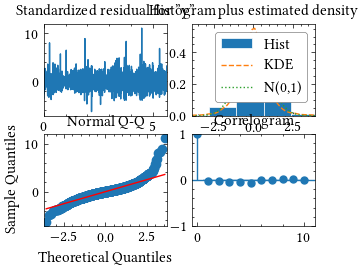

In [39]:
_ = model.plot_diagnostics()

## pre-whiten the endog input

In [40]:
filt_exog = sm.tsa.filters.convolution_filter(x, np.r_[1, -model.params[:-1]], nsides=1)
filt_endog = sm.tsa.filters.convolution_filter(
    y, np.r_[1, -model.params[:-1]], nsides=1
)

filt_exog = filt_exog[~np.isnan(filt_exog)]
filt_endog = filt_endog[~np.isnan(filt_endog)]

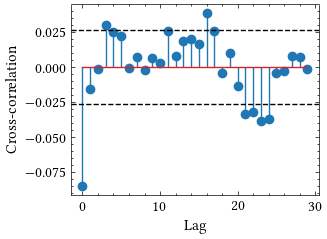

In [41]:
fig, ax = plt.subplots()

max_lags = 30

ccf = sm.tsa.ccf(filt_exog, filt_endog)
ax.stem(np.arange(0, max_lags, 1), ccf[:max_lags])

ax.axhline(-1.96 / np.sqrt(len(filt_exog)), color="k", ls="--")
ax.axhline(1.96 / np.sqrt(len(filt_exog)), color="k", ls="--")

ax.set_xlabel("Lag")
ax.set_ylabel("Cross-correlation")

fig.tight_layout()

arx handles auto correlation and cross correlation.

You find auto correlation using PACF plot as normal.

If you didn't remove auto correlation, this would look like cross correlation, so you apply pre whitening filter to handle this.

Then ccf plot mostly is now true cross correlation.

# fit AR-X model

In [42]:
model = sm.tsa.AutoReg(
    endog=y,
    exog=x,
    lags=6,
    trend="n",
)
res = model.fit()

In [43]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                 5663
Model:                   AutoReg-X(6)   Log Likelihood               12706.654
Method:               Conditional MLE   S.D. of innovations              0.026
Date:                Sun, 28 Aug 2022   AIC                         -25397.308
Time:                        15:57:26   BIC                         -25344.183
Sample:                             6   HQIC                        -25378.805
                                 5663                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.5576      0.013     42.531      0.000       0.532       0.583
y.L2           0.0539      0.015      3.590      0.000       0.024       0.083
y.L3           0.0210      0.015      1.397      0.162      -0.008       0.050
y.L4           0.0011      0.015      0.073      0.941      -0.028       0.031
y.L5        2.621e-05      0.015      0.002      0.999      -0.029       0.029
y.L6          -0.0798      0.012     -6.422      0.000      -0.104      -0.055
x1            -0.0062      0.000    -29.680      0.000      -0.007      -0.006
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2371           -0.4539j            1.3177           -0.0560
AR.2            1.2371           +0.4539j            1.3177            0.0560
AR.3            0.1778           -1.5915j            1.6014           -0.2323
AR.4            0.1778           +1.5915j            1.6014            0.2323
AR.5           -1.4148           -0.9006j            1.6771           -0.4098
AR.6           -1.4148           +0.9006j            1.6771            0.4098
-----------------------------------------------------------------------------
"""

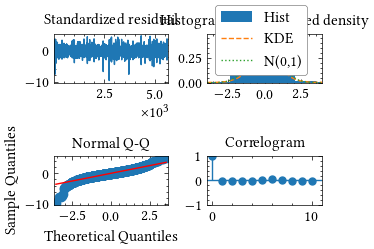

In [44]:
_ = res.plot_diagnostics()
plt.tight_layout()

In [45]:
x_test = daily_test_df.air_temperature.values.reshape(-1, 1)
y_test = daily_test_df.freq.values

In [46]:
daily_train_preds = np.nan_to_num(res.forecast(steps=len(x), exog=x))
daily_test_preds = np.nan_to_num(res.forecast(steps=len(x_test), exog=x_test))

daily_train_res = y - daily_train_preds
daily_test_res = y_test - daily_test_preds

In [47]:
from sklearn.metrics import mean_squared_error

print("Train RMSE: %.3f Hz" % (np.sqrt(mean_squared_error(y, daily_train_preds))))
print("Test RMSE: %.3f Hz" % (np.sqrt(mean_squared_error(y_test, daily_test_preds))))

Train RMSE: 0.032 Hz
Test RMSE: 0.031 Hz


In [48]:
sm.stats.durbin_watson(daily_train_res)

0.8342725544904287

In [49]:
sm.stats.durbin_watson(daily_test_res)

0.8217163385478101

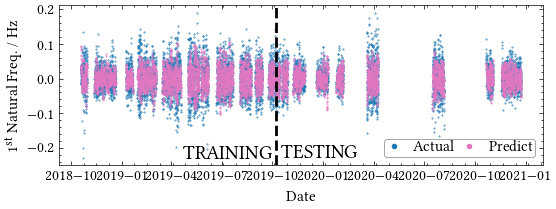

In [50]:
figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)

actual_paras = dict(ls="", marker=".", c=actual_col, markersize=0.75, rasterized=True)
predict_paras = dict(ls="", marker=".", c=predict_col, markersize=0.75, rasterized=True)

ax.plot(daily_train_df.freq, label="Actual", **actual_paras)
ax.plot(daily_test_df.freq, label="_Actual", **actual_paras)

ax.plot(daily_train_df.index, daily_train_preds, **predict_paras, label="Predict")
ax.plot(daily_test_df.index, daily_test_preds, **predict_paras, label="_Predict")

ax.axvline(split_ind, ls="--", c="k", lw="2.0")
ax.annotate(
    "TRAINING",
    xy=(
        split_ind - pd.Timedelta("200H"),
        ax.transData.inverted().transform(
            (0.0, ax.transAxes.transform((0.0, 0.01))[1])
        )[1],
    ),
    ha="right",
    va="bottom",
    fontsize=14.0,
    fontweight="bold",
)
ax.annotate(
    "TESTING",
    xy=(
        split_ind + pd.Timedelta("200H"),
        ax.transData.inverted().transform(
            (0.0, ax.transAxes.transform((0.0, 0.01))[1])
        )[1],
    ),
    ha="left",
    va="bottom",
    fontsize=14.0,
    fontweight="bold",
    zorder=10,
)

ax.set_xlabel("Date")
ax.set_ylabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}")
legend = ax.legend(
    loc="lower right", ncol=2, borderpad=0.15, handlelength=1.0, columnspacing=0.5
)

for lh in legend.legendHandles:
    lh.set_markersize(6)

fig.tight_layout()
ajf_plts.save_fig(fig, "figDailyARXfit.pdf")

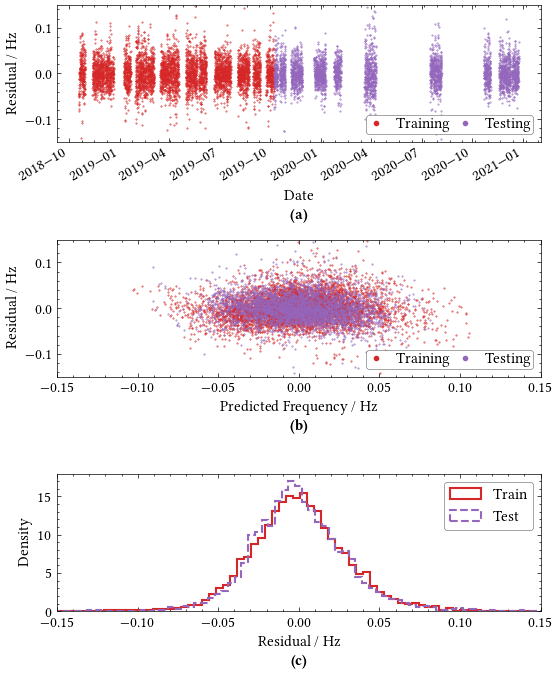

In [51]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, 3.0 * ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, nrows=3)

props = dict(ls="", marker=".", markersize=0.75, rasterized=True)

axes[0].plot(
    train_df.dropna().index, daily_train_res, **props, c=train_col, label="Training"
)
axes[0].plot(
    test_df.dropna().index, daily_test_res, **props, c=test_col, label="Testing"
)

axes[0].set_xlabel("Date")
axes[0].set_ylabel("Residual / Hz")
plt.setp(axes[0].get_xticklabels(), rotation=30, ha="right")

axes[1].plot(daily_train_preds, daily_train_res, **props, c=train_col, label="Training")
axes[1].plot(daily_test_preds, daily_test_res, **props, c=test_col, label="Testing")
axes[1].set_xlabel("Predicted Frequency / Hz")
axes[1].set_ylabel("Residual / Hz")

ax_props = dict(bins=100, density=True, histtype="step", lw=1.5)

axes[2].hist(daily_train_res, **ax_props, ec=train_col, label="Train")
axes[2].hist(daily_test_res, **ax_props, ec=test_col, label="Test")
axes[2].set_xlabel(r"Air Temperature / \unit{\celsius}")
axes[2].set_xlabel(r"Residual / \unit{\hertz}")
axes[2].set_ylabel("Density")
legend = axes[2].legend(loc="upper right")


# axes[2].plot(daily_train_res[:-1], daily_train_res[1:], **props, c=train_col, label='Training')
# axes[2].plot(daily_test_res[:-1], daily_test_res[1:], **props, c=test_col, label='Testing')
# axes[2].set_xlabel(r"Air Temperature / \unit{\celsius}")
# axes[2].set_xlabel(r"Residual$\;\left[{t-1}\right]$ / \unit{\hertz}")
# axes[2].set_ylabel(r"Residual$\;\left[{t}\right]$ / \unit{\hertz}")

for ax in axes[:-1]:
    legend = ax.legend(
        loc="lower right", ncol=2, borderpad=0.15, handlelength=1.0, columnspacing=0.5
    )
    for lh in legend.legendHandles:
        lh.set_markersize(6)
        lh.set_alpha(1.0)
    ax.set_ylim((-0.15, 0.15))

for ax in axes[1:]:
    ax.set_xlim((-0.15, 0.15))

ajf_plts.caption_axes(axes)
fig.tight_layout()

# put the models back together

In [52]:
train_preds = trend_train_preds + daily_train_preds
test_preds = trend_test_preds + daily_test_preds

train_res = train_df.dropna().freq - train_preds
test_res = test_df.dropna().freq - test_preds

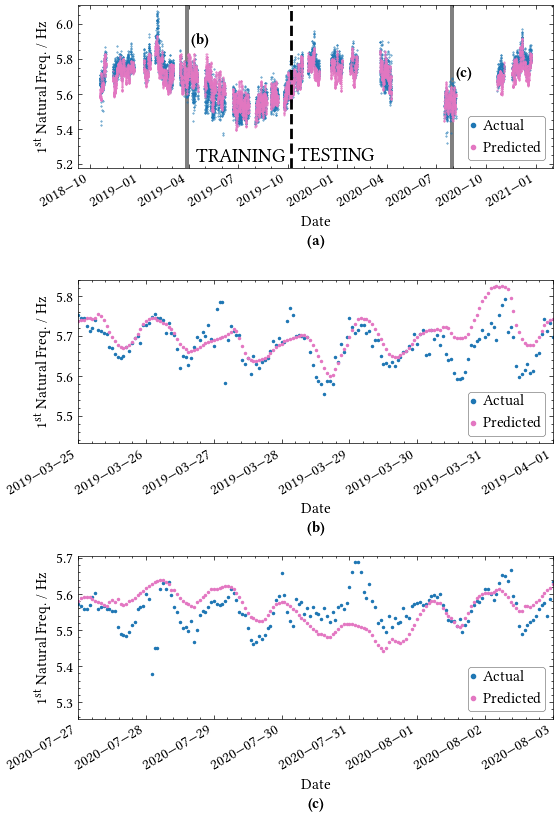

In [53]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, ajf_plts.text_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=1, nrows=3)

axes = axes.ravel()

props = dict(ls="", marker=".", markersize=0.75, rasterized=True)

# OVERALL PLOT
axes[0].plot(train_df.freq, **props, c=actual_col, label="Actual")
axes[0].plot(test_df.freq, **props, c=actual_col, label="_Actual")

axes[0].plot(
    train_df.dropna().index, train_preds, **props, c=predict_col, label="Predicted"
)
axes[0].plot(
    test_df.dropna().index, test_preds, **props, c=predict_col, label="_Predicted"
)

axes[0].xaxis.set_major_locator(mpl.dates.MonthLocator(interval=3))
axes[0].xaxis.set_minor_locator(mpl.dates.MonthLocator())


# TRAIN PLOT
train_start = pd.to_datetime("2019-3-25")
train_end = train_start + pd.Timedelta("7d")
train_mask = (train_start <= train_df.dropna().index) * (
    train_df.dropna().index <= train_end
)

props["markersize"] = 3.0

axes[1].plot(
    train_df.dropna().freq.loc[train_mask], **props, c=actual_col, label="Actual"
)
axes[1].plot(
    train_df.dropna().index[train_mask],
    train_preds[train_mask],
    **props,
    c=predict_col,
    label="Predicted",
)

axes[1].set_xlim((train_start, train_end))


# TEST PLOT
test_start = pd.to_datetime("2020-07-27")
test_end = test_start + pd.Timedelta("7d")
test_mask = (test_start <= test_df.dropna().index) * (
    test_df.dropna().index <= test_end
)

axes[2].plot(
    test_df.dropna().freq.loc[test_mask],
    **props,
    c=actual_col,
    label="Actual",
)
axes[2].plot(
    test_df.dropna().index[test_mask],
    test_preds[test_mask],
    **props,
    c=predict_col,
    label="Predicted",
)

axes[2].set_xlim((test_start, test_end))


for ax in axes:
    ax.set_xlabel("Date")
    ax.set_ylabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}")
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
    ax.set_ylim(ax.get_ylim() * np.array([0.98, 1.0]))
    legend = ax.legend(
        loc="lower right", borderpad=0.25, handlelength=0.25, handletextpad=0.5
    )
    for lh in legend.legendHandles:
        lh.set_markersize(6)

for ax in axes[1:]:
    ax.xaxis.set_major_locator(mpl.dates.DayLocator())
    ax.xaxis.set_major_formatter(mpl.dates.AutoDateFormatter(mpl.dates.DateLocator()))

ajf_plts.annotate_train_test_split(
    ax=axes[0], split_x_val=split_ind, label_x_offset=pd.Timedelta("300H")
)

axes[0].axvspan(train_start, train_end, **axvspan_paras)
axes[0].annotate(
    r"\bfseries (b)",
    xy=(
        train_end + pd.Timedelta("100H"),
        axes[0]
        .transData.inverted()
        .transform((0.0, axes[0].transAxes.transform((0.0, 0.82))[1]))[1],
    ),
    ha="left",
    va="top",
    fontsize=11.0,
)

axes[0].axvspan(test_start, test_end, **axvspan_paras)
axes[0].annotate(
    r"\bfseries (c)",
    xy=(
        test_end + pd.Timedelta("100H"),
        axes[0]
        .transData.inverted()
        .transform((0.0, axes[0].transAxes.transform((0.0, 0.62))[1]))[1],
    ),
    ha="left",
    va="top",
    fontsize=11.0,
)

ajf_plts.caption_axes(axes)
fig.tight_layout()

AttributeError: 'Rectangle' object has no attribute 'set_markersize'

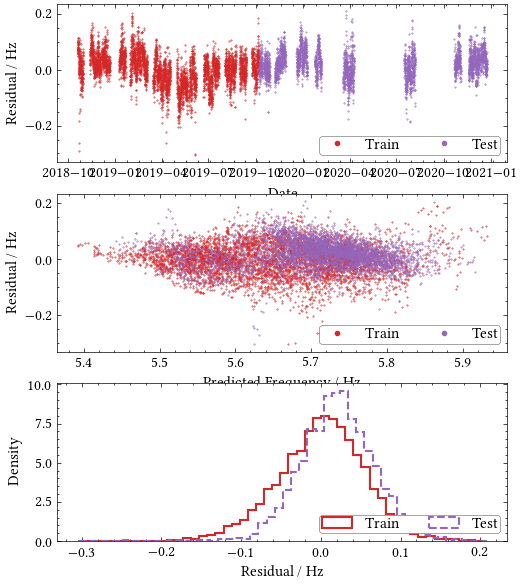

In [54]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, 3.0 * ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, nrows=3)

props = dict(ls="", marker=".", markersize=0.75, rasterized=True)

axes[0].plot(train_df.dropna().index, train_res, **props, c=train_col, label="Train")
axes[0].plot(test_df.dropna().index, test_res, **props, c=test_col, label="Test")

axes[0].set_xlabel("Date")
axes[0].set_ylabel("Residual / Hz")

axes[1].plot(train_preds, train_res, **props, c=train_col, label="Train")
axes[1].plot(test_preds, test_res, **props, c=test_col, label="Test")
axes[1].set_xlabel("Predicted Frequency / Hz")
axes[1].set_ylabel("Residual / Hz")


# ax_props = dict(ls='', marker='.', markeredgecolor='None', alpha=0.3)
#
# axes[2].plot(train_res[:-1], train_res[1:], **ax_props, c=train_col, label='Train')
# axes[2].plot(test_res[:-1], test_res[1:], **ax_props, c=test_col, label='Test')
# axes[2].set_xlabel(r"Air Temperature / \unit{\celsius}")
# axes[2].set_xlabel(r"Residual$\;\left[{t-1}\right]$ / \unit{\hertz}")
# axes[2].set_ylabel(r"Residual$\;\left[{t}\right]$ / \unit{\hertz}")

ax_props = dict(bins=50, density=True, histtype="step", lw=1.5)

axes[2].hist(train_res, **ax_props, ec=train_col, label="Train")
axes[2].hist(test_res, **ax_props, ec=test_col, label="Test")
axes[2].set_xlabel(r"Air Temperature / \unit{\celsius}")
axes[2].set_xlabel(r"Residual / \unit{\hertz}")
axes[2].set_ylabel("Density")
legend = axes[2].legend(loc="upper right")

for ax in axes:
    legend = ax.legend(loc="lower right", ncol=2, borderpad=0.15)
    for lh in legend.legendHandles:
        lh.set_markersize(6)
        lh.set_alpha(1.0)


for ax in axes:
    ax.set_ylim((-0.2, 0.2))
axes[-1].set_xlim((-0.2, 0.2))

ajf_plts.caption_axes(axes)
fig.tight_layout()

In [55]:
sm.stats.durbin_watson(train_res)

0.274707199705057

In [56]:
sm.stats.durbin_watson(test_res)

0.29650238700083925

In [57]:
from sklearn.metrics import mean_squared_error

print(
    "Train RMSE: %.3f Hz"
    % (
        np.sqrt(
            mean_squared_error(
                train_df.dropna().freq, trend_train_preds + daily_train_preds
            )
        )
    )
)
print(
    "Test RMSE: %.3f Hz"
    % (
        np.sqrt(
            mean_squared_error(
                test_df.dropna().freq, trend_test_preds + daily_test_preds
            )
        )
    )
)

Train RMSE: 0.055 Hz
Test RMSE: 0.051 Hz
